<a href="https://colab.research.google.com/github/agw2005/lagrange-newton-interpolation-img-scaling/blob/master/app.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Dependencies

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import time
import urllib.request
from skimage.metrics import mean_squared_error, peak_signal_noise_ratio

# lagrange_interpolate( )

In [ ]:
def lagrange_interpolate(x_values, y_values, x):
    result = 0
    n = len(x_values)
    for i in range(n):
        term = y_values[i]
        for j in range(n):
            if i != j:
                term *= (x - x_values[j]) / (x_values[i] - x_values[j])
        result += term
    return result

Fungsi ini mengimplementasikan rumus interpolasi Lagrange, metode interpolasi polinomial klasik yang digunakan untuk memperkirakan nilai suatu fungsi pada titik tertentu berdasarkan titik sampel yang diketahui. Input terdiri dari:
> `x_values` : koordinat x yang diketahui

> `y_values`:  nilai fungsi terkait pada koordinat x tersebut

> `x` : titik spesifik tempat Anda ingin menginterpolasi suatu nilai

Fungsi ini membangun polinomial basis Lagrange $L_i(x)$ di dalam loop bersarang, di mana setiap suku dalam penjumlahan dibangun menggunakan produk $\frac{(x-x_j)}{(x_i-x_j)}$ untuk semua $j \neq 0$. Suku-suku ini kemudian dibobot oleh `y_values[i]` terkait dan dijumlahkan untuk memberikan hasil interpolasi.

# newton_divided_diff( )

In [ ]:
def newton_divided_diff(x_values, y_values):
    n = len(x_values)
    coef = np.copy(y_values).astype(float)
    for j in range(1, n):
        for i in range(n - 1, j - 1, -1):
            coef[i] = (coef[i] - coef[i - 1]) / (x_values[i] - x_values[i - j])
    return coef

Fungsi ini menghitung tabel selisih terbagi yang digunakan dalam bentuk interpolasi polinomial Newton. Tujuannya adalah untuk menghasilkan koefisien untuk polinomial interpolasi Newton saat diketahui:
> `x_values` : koordinat x sampel,

> `y_values` : nilai fungsi pada titik tersebut.

Diawali dengan menyalin `y_values` ke dalam array `coef`, yang akan diperbarui di tempat untuk menjadi daftar koefisien Newton. Perulangan ganda menghitung selisih terbagi secara berulang. Untuk setiap level `j`, ia menghitung selisih antara pasangan elemen dalam `coef`, dibagi dengan jarak nilai x yang sesuai. Pada akhir perulangan, `coef[i]` menyimpan koefisien untuk suku ke-`i` dari polinomial interpolasi Newton.

# newton_interpolate( )

In [ ]:
def newton_interpolate(x_values, coef, x):
    n = len(x_values)
    result = coef[0]
    term = 1.0
    for i in range(1, n):
        term *= (x - x_values[i - 1])
        result += coef[i] * term
    return result

Fungsi ini melakukan interpolasi Newton menggunakan koefisien yang dihasilkan dari fungsi `newton_divided_diff` sebelumnya. Fungsi ini mengambil:

> `x_values` : koordinat x asli yang digunakan untuk menghasilkan koefisien,

> `coef` : array koefisien Newton,

> `x` : titik target tempat interpolasi dievaluasi.

Interpolasi dihitung dengan membangun polinomial secara bertahap. Fungsi ini dimulai dari suku konstan (`coef[0]`), dan untuk setiap derajat `i`, mengalikan suku akumulasi dengan $(x-x_{i-1})$, lalu menambahkan hasil yang diskalakan oleh koefisien `coef[i]` yang sesuai. Konstruksi langkah demi langkah ini mencerminkan bentuk Newton:
$$P(x)=a_0+a_1(x-x_0)+a_2(x-x_0)(x-x_1)+\cdots$$


# get_neighbors( )

In [ ]:
def get_neighbors(x_values, y_values, x, k=4):
    n = len(x_values)
    distances = np.abs(np.array(x_values) - x)
    indices = np.argsort(distances)[:k]
    indices = sorted(indices)
    return [x_values[i] for i in indices], [y_values[i] for i in indices]

Fungsi ini memilih `k` titik tetangga terdekat di sekitar target `x` dari sekumpulan `x_values` dan `y_values` yang sesuai. Tujuannya adalah untuk melokalisasi interpolasi sehingga hanya diterapkan pada sampel di dekatnya, yang dapat meningkatkan akurasi dan stabilitas untuk fungsi dengan variasi cepat atau saat bekerja dengan kumpulan data besar.

Pertama-tama, fungsi ini menghitung jarak absolut dari setiap `x_value` ke target `x`, mengurutkannya, dan memilih indeks dari `k` nilai terdekat. Indeks ini kemudian diurutkan untuk mempertahankan urutan yang meningkat (penting untuk algoritme interpolasi seperti Newton). Fungsi ini mengembalikan nilai `x` dan `y` yang dipilih sebagai dua `list` baru, siap untuk diteruskan ke rutinitas interpolasi Lagrange atau Newton.

# lagrange_local_interpolate( )

In [ ]:
def lagrange_local_interpolate(x_values, y_values, x, k=4):
    xs, ys = get_neighbors(x_values, y_values, x, k)
    return lagrange_interpolate(xs, ys, x)

Fungsi ini menerapkan interpolasi Lagrange secara lokal dengan menggabungkan dua komponen sebelumnya. Pertama-tama fungsi ini menemukan `k` tetangga terdekat ke titik target `x` menggunakan `get_neighbors()`, lalu menerapkan fungsi `lagrange_interpolate()` hanya pada titik-titik yang dipilih.

Alasan penggunaan interpolasi lokal daripada global adalah untuk mengurangi biaya komputasi. Dengan fungsi ini, komputasi interpolasi hanya menggunakan subset data yang lebih kecil dan lebih relevan yang berpusat di sekitar titik yang diinginkan.

# newton_local_interpolate( )

In [ ]:
def newton_local_interpolate(x_values, y_values, x, k=4):
    xs, ys = get_neighbors(x_values, y_values, x, k)
    coef = newton_divided_diff(xs, ys)
    return newton_interpolate(xs, coef, x)

Fungsi ini melakukan interpolasi Newton lokal yang mencerminkan struktur fungsi `lagrange_local_interpolate()` sebelumnya tetapi menggunakan metode Newton sebagai gantinya. Pertama-tama, fungsi ini memilih `k` tetangga terdekat ke target `x` menggunakan `get_neighbors()`. Kemudian, fungsi ini menghitung koefisien selisih terbagi Newton dari tetangga-tetangga ini dengan fungsi `newton_divided_diff()`, dan akhirnya mengevaluasi hasil interpolasi menggunakan `newton_interpolate()`.

Dengan membatasi interpolasi ke subset titik-titik terdekat, metode ini mengurangi biaya komputasi, terutama pada citra yang memiliki ribuan pixel.

# upscale_image( )

In [ ]:
def upscale_image(image, method='lagrange', k=4):
    orig_h, orig_w = image.shape
    new_h = 2 * (orig_h - 1) + 1
    new_w = 2 * (orig_w - 1) + 1
    upscaled = np.zeros((new_h, new_w))

    x_old = list(range(orig_w))
    y_old = list(range(orig_h))
    x_new = np.linspace(0, orig_w - 1, new_w)
    y_new = np.linspace(0, orig_h - 1, new_h)

    # Step 1: Row-wise interpolation (horizontal)
    row_interpolated = np.zeros((orig_h, new_w))
    for i in range(orig_h):
        for j, x in enumerate(x_new):
            if method == 'lagrange':
                row_interpolated[i][j] = lagrange_local_interpolate(x_old, image[i], x, k)
            elif method == 'newton':
                row_interpolated[i][j] = newton_local_interpolate(x_old, image[i], x, k)

    # Step 2: Column-wise interpolation (vertical)
    for j in range(new_w):
        col = row_interpolated[:, j]
        for i, y in enumerate(y_new):
            if method == 'lagrange':
                upscaled[i][j] = lagrange_local_interpolate(y_old, col, y, k)
            elif method == 'newton':
                upscaled[i][j] = newton_local_interpolate(y_old, col, y, k)

    return np.clip(upscaled, 0, 255)

Fungsi ini melakukan peningkatan skala gambar menggunakan interpolasi dua kali: pertama secara horizontal di seluruh baris, kemudian secara vertikal di seluruh kolom. Fungsi ini mendukung metode interpolasi Lagrange atau Newton yang diterapkan secara lokal.

Peningkatan skala menggandakan dimensi menggunakan rumus $2(n-1)+1$, yang memastikan bahwa piksel baru disisipkan di antara setiap pasangan piksel yang ada (termasuk di tepi), sehingga menghasilkan keluaran beresolusi tinggi. Untuk setiap baris dalam gambar asli, fungsi ini menginterpolasi nilai piksel di sepanjang sumbu horizontal untuk menghasilkan baris yang lebih lebar. Hasil antara ini kemudian diproses kolom demi kolom untuk diinterpolasi secara vertikal dan menghasilkan gambar akhir yang ditingkatkan skalanya.

Metode interpolasi dipilih melalui argumen `method`, dan argumen `k` mengontrol berapa banyak piksel tetangga yang digunakan selama interpolasi, yang memengaruhi kinerja dan kualitas visual.

# bilinear_upscale( )

In [ ]:
def bilinear_upscale(image):
    orig_h, orig_w = image.shape
    new_h = 2 * (orig_h - 1) + 1
    new_w = 2 * (orig_w - 1) + 1
    return cv2.resize(image, (new_w, new_h), interpolation=cv2.INTER_LINEAR)

Fungsi ini melakukan peningkatan skala gambar berbasis interpolasi bilinear menggunakan `OpenCV`. Fungsi ini mengubah ukuran gambar input ke bentuk target dengan kalkulasi dimensi yang sama yang digunakan sebelumnya yakni $2(n-1)+1$, yang secara efektif menggandakan resolusi sambil memasukkan piksel yang diinterpolasi di antara piksel yang sudah ada.

Operasi utama dilakukan menggunakan `cv2.resize()` dengan flag `INTER_LINEAR`, yang memberi tahu `OpenCV` untuk menerapkan interpolasi bilinear, yaitu teknik standar yang banyak digunakan yang memperkirakan nilai piksel baru berdasarkan kombinasi linear dari empat piksel di sekitarnya. Fungsi ini digunakan di sini sebagai metode dasar atau referensi untuk perbandingan dengan pendekatan Newton dan Lagrange yang lebih kompleks.

# evaluate_upscaling_methods( )

In [ ]:
def evaluate_upscaling_methods(input_image):
    methods = ['lagrange', 'newton']
    results = {}

    # Use bilinear as ground truth
    up_bilinear = bilinear_upscale(input_image)

    for method in methods:
        start_time = time.time()
        up_result = upscale_image(input_image, method=method)
        duration = time.time() - start_time

        # Align size
        up_result = np.clip(up_result, 0, 255).astype(np.uint8)
        up_bilinear_aligned = up_bilinear[:up_result.shape[0], :up_result.shape[1]]

        mse = mean_squared_error(up_bilinear_aligned, up_result)
        psnr = peak_signal_noise_ratio(up_bilinear_aligned, up_result, data_range=255)

        results[method] = {
            'output': up_result,
            'time': duration,
            'mse': mse,
            'psnr': psnr
        }

    return up_bilinear, results

Fungsi ini mengevaluasi seberapa baik metode interpolasi Lagrange dan Newton meningkatkan skala gambar, menggunakan interpolasi bilinear sebagai standar referensi. Pertama-tama, fungsi ini menghasilkan gambar yang ditingkatkan skalanya secara bilinear (yang berfungsi sebagai _pseudo-ground-truth_ untuk perbandingan visual dan numerik). Kemudian, untuk setiap metode:

1. Mengukur skala gambar menggunakan interpolasi (`upscale_image()`)
2. Mengukur waktu yang dibutuhkan untuk proses tersebut
3. Mengonversi hasil ke format 8-bit dan memastikannya nilainya ada pada rentang $[0, 255]$
4. Menyelaraskan ukuran hasil dengan versi bilinear jika ada ketidakcocokan karena pembulatan
5. Menghitung _mean squared error_ (MSE) dan _peak signal-to-noise ratio_ (PSNR) antara hasil dan gambar bilinear

Semua metrik dan hasil kinerja disimpan dalam `dictionary` yang diberi `key` berdasarkan nama metode.

# show_comparison_with_metrics( )

In [ ]:
def show_comparison_with_metrics(input_image, bilinear_result, method_results, title='Upscaling Comparison'):
    # Print Metrics as Text
    print(f"📊 {title} Metrics:\n")
    for method, metrics in method_results.items():
        image = metrics['output']
        mse = metrics['mse']
        psnr = metrics['psnr']
        runtime = metrics['time']

        print(f"{method.capitalize()} Upscaling:")
        print(f"  - MSE  : {mse:.2f}")
        print(f"  - PSNR : {psnr:.2f} dB")
        print(f"  - Time : {runtime:.2f} s\n")

    # Plot 2x2 Comparison
    fig, axs = plt.subplots(2, 2, figsize=(10, 10))

    axs[0, 0].imshow(input_image, cmap='gray', vmin=0, vmax=255)
    axs[0, 0].set_title("Original")
    axs[0, 0].axis('off')

    axs[0, 1].imshow(bilinear_result, cmap='gray', vmin=0, vmax=255)
    axs[0, 1].set_title("Bilinear (OpenCV)")
    axs[0, 1].axis('off')

    axs[1, 0].imshow(method_results['lagrange']['output'], cmap='gray', vmin=0, vmax=255)
    axs[1, 0].set_title("Lagrange")
    axs[1, 0].axis('off')

    axs[1, 1].imshow(method_results['newton']['output'], cmap='gray', vmin=0, vmax=255)
    axs[1, 1].set_title("Newton")
    axs[1, 1].axis('off')

    plt.tight_layout()
    plt.show()

Fungsi ini memvisualisasikan dan melaporkan kinerja metode peningkatan skala dengan:

1. Mencetak metrik numerik (MSE, PSNR, dan waktu proses) untuk setiap metode menggunakan teks yang diformat
2. Menampilkan kisi perbandingan gambar 2×2 yang menunjukkan:
   * Gambar asli
   * Hasil bilinear (garis-dasar)
   * Hasil metode Lagrange
   * Hasil metode Newton

Setiap gambar merupakan _graysale_ `(cmap='gray')` dan intensitasnya dibatasi pada rentang piksel $[0, 255]$. Tata letak dirancang untuk memudahkan perbandingan visual dan metrik secara berdampingan, membantu pengguna mengevaluasi kinerja kualitatif dan kuantitatif.

# Contoh dengan gambar $4\times4$

📊 4x4 Upscaling Comparison Metrics:

Lagrange Upscaling:
  - MSE  : 1.27
  - PSNR : 47.11 dB
  - Time : 0.01 s

Newton Upscaling:
  - MSE  : 1.27
  - PSNR : 47.11 dB
  - Time : 0.00 s



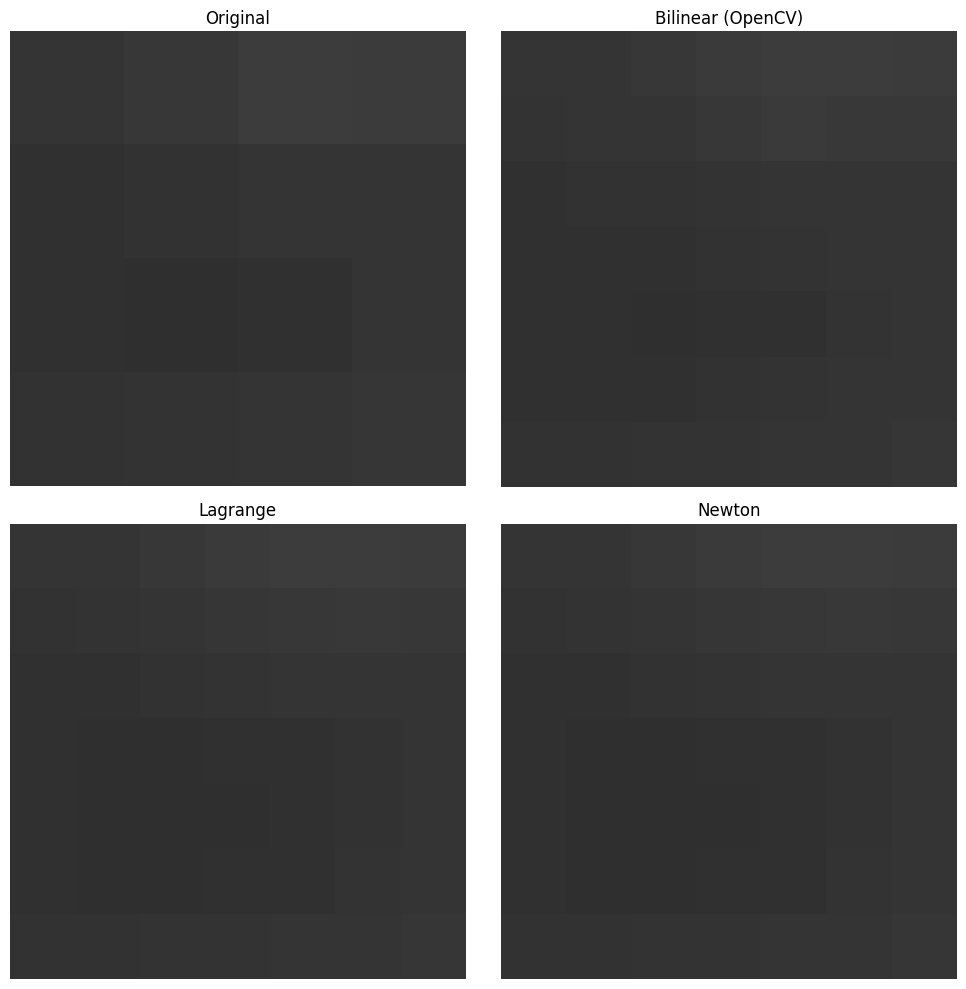

In [ ]:
# Convert input to proper format
input_image = np.array([
    [52, 55, 61, 59],
    [49, 50, 52, 53],
    [48, 47, 49, 52],
    [50, 51, 52, 54]
], dtype=np.uint8)

# Evaluate
bilinear_result, method_results = evaluate_upscaling_methods(input_image)

# Show comparison
show_comparison_with_metrics(input_image, bilinear_result, method_results, title='4x4 Upscaling Comparison')

Menjalankan kasus conoth pada gambar _grayscale_ 4x4 untuk menunjukkan dan memvalidasi proses peningkatan skala. Sel ini melakukan hal berikut:

1. Menentukan gambar _grayscale_ kecil menggunakan array `NumPy` dengan nilai intensitas antara `47` dan `61`. Ini berfungsi sebagai input terkontrol sederhana

2. Mengevaluasi peningkatan skala menggunakan metode `Lagrange` dan `Newton` dengan memanggil `evaluate_upscaling_methods()`, yang juga menghasilkan referensi bilinear untuk perbandingan

3. Menampilkan hasil dan metrik menggunakan `show_comparison_with_metrics()`, yang mencetak nilai kinerja dan memvisualisasikan semua gambar yang ditingkatkan skalanya dalam satu grafik

Ini berfungsi untuk memverifikasi bahwa interpolasi berfungsi seperti yang diharapkan.

# Contoh dengan gambar $300\times300$

📊 100x100 Upscaling Comparison Metrics:

Lagrange Upscaling:
  - MSE  : 13.02
  - PSNR : 36.98 dB
  - Time : 24.11 s

Newton Upscaling:
  - MSE  : 13.02
  - PSNR : 36.98 dB
  - Time : 26.01 s



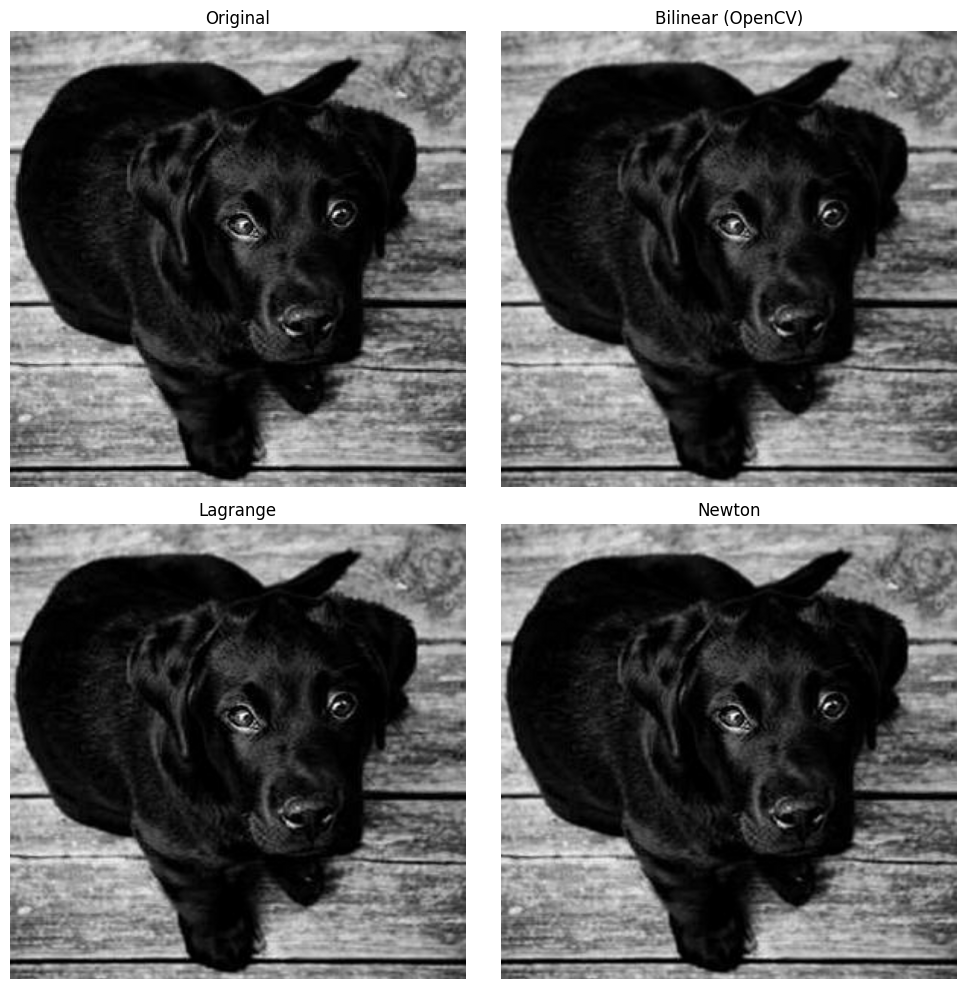

In [ ]:
image_url = 'https://picsum.photos/id/237/300/300'  # 300x300 grayscale image
resp = urllib.request.urlopen(image_url)
image_array = np.asarray(bytearray(resp.read()), dtype=np.uint8)
real_input_image = cv2.imdecode(image_array, cv2.IMREAD_GRAYSCALE)

# Evaluate
bilinear_result, method_results = evaluate_upscaling_methods(real_input_image)

# Show comparison
show_comparison_with_metrics(real_input_image, bilinear_result, method_results, title='300x300 Upscaling Comparison')

Sel ini melanjutkan pengujian ke gambar skala abu-abu yang lebih besar dan nyata

1. Gambar diundah dari internet menggunakan `urllib` dan mengubahnya menjadi _grayscale_ dengan `cv2.imdecode(...)` dan argumen `cv2.IMREAD_GRAYSCALE`

2. Selanjutnya akan dijalankan alur evaluasi yang sama dengan fungsi `evaluate_upscaling_methods()` untuk meningkatkan skala gambar menggunakan interpolasi `Lagrange` dan `Newton`, dengan interpolasi bilinear sebagai referensi

3. Setelah itu, hasil akan divisualisasikan serta metrik komputasinya dengan `show_comparison_with_metrics()`, kali ini diberi label sebagai `"Perbandingan Peningkatan Skala 100x100"`

Langkah terakhir ini menunjukkan bahwa metode interpolasi yang diterapkan berskala melampaui contoh sintetis dan dapat menangani gambar nyata dengan resolusi lebih tinggi.